In [2]:
import os, sys
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
## Finger prints
#from map4 import MAP4Calculator
#import tmap as tm
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
## Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
## Metrics
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [3]:
plt.style.use("/home/dm/Dibyendu/Projects/CVSampler/NoteBooks/style.txt")
plt.rcParams['font.family'] = "C059"

In [4]:
# freesolv
freesoldf = pd.read_csv("../DataSets/freesolv.csv")
freesoldf = freesoldf.drop("Unnamed: 0", axis=1)
# MNSol
mnsoldf = pd.read_csv("../DataSets/mnsol.csv", sep = ";")
mnsoldf_water = mnsoldf.loc[mnsoldf['Solvent'] == 'water']
mnsoldf = mnsoldf_water.reset_index().drop("index", axis = 1)
# CombiSolv-EXP
combisolv = pd.read_csv("../DataSets/CombiSolv-Exp-8780.csv", sep = ",")

## Combisolv dataset preparation and cleaning..
combisolv['SolventSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[0])
combisolv['SoluteSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[1])
combisolv['Solute'] = "solute"
combisolv['Solvent'] = "solvent"
combisolv.rename(columns = {'dgsolv':'DeltaGsolv'}, inplace = True)
combisolv.drop(columns=['ssid'], inplace = True)
combisolv = combisolv.loc[combisolv['SolventSMILES'] == "O"]
combisolv.reset_index().drop("index", axis = 1, inplace = True)
combisolv = combisolv[['Solute', 'Solvent', 'SoluteSMILES',
                        'SolventSMILES', 'DeltaGsolv']]

## Smiles to Mol conversion
freesoldf['mol'] = freesoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
mnsoldf['mol'] = mnsoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
combisolv['mol'] = combisolv['SoluteSMILES'].apply(Chem.MolFromSmiles)

[20:38:43] WARNING: not removing hydrogen atom without neighbors


In [11]:
def generate_fingerprints(dim):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=1, fpSize=dim)
    ecfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=dim)
    rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=dim)
    apgen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=dim)
    ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=dim)

    ## Fingerprint generation
    freesoldf['morganfp'] = freesoldf['mol'].apply(mfpgen.GetFingerprint)
    freesoldf['rdkgen'] = freesoldf['mol'].apply(rdkgen.GetFingerprint)
    freesoldf['apgen'] = freesoldf['mol'].apply(apgen.GetFingerprint)
    freesoldf['ttgen'] = freesoldf['mol'].apply(ttgen.GetFingerprint)
    freesoldf['ecfp'] = freesoldf['mol'].apply(ecfpgen.GetFingerprint)

    mnsoldf['morganfp'] = mnsoldf['mol'].apply(mfpgen.GetFingerprint)
    mnsoldf['rdkgen'] = mnsoldf['mol'].apply(rdkgen.GetFingerprint)
    mnsoldf['apgen'] = mnsoldf['mol'].apply(apgen.GetFingerprint)
    mnsoldf['ttgen'] = mnsoldf['mol'].apply(ttgen.GetFingerprint)
    mnsoldf['ecfp'] = mnsoldf['mol'].apply(ecfpgen.GetFingerprint)

    combisolv['ecfp'] = combisolv['mol'].apply(ecfpgen.GetFingerprint)
    combisolv['morganfp'] = combisolv['mol'].apply(mfpgen.GetFingerprint)
    combisolv['rdkgen'] = combisolv['mol'].apply(rdkgen.GetFingerprint)
    combisolv['apgen'] = combisolv['mol'].apply(apgen.GetFingerprint)
    combisolv['ttgen'] = combisolv['mol'].apply(ttgen.GetFingerprint)

    mnsol_morgan = np.vstack(mnsoldf['morganfp'].values)
    fsol_morgan = np.vstack(freesoldf['morganfp'].values)
    csol_morgan = np.vstack(combisolv['morganfp'].values)

    mnsol_ecfp = np.vstack(mnsoldf['ecfp'].values)
    fsol_ecfp = np.vstack(freesoldf['ecfp'].values)
    csol_ecfp = np.vstack(combisolv['ecfp'].values)

    # MAP4 keys
    #mnsol_map4 = joblib.load('mnsol_map4.pkl')
    mnsol_target = mnsoldf['DeltaGsolv'].values
    #csol_map4 = joblib.load('csol_map4.pkl')
    csol_target = combisolv['DeltaGsolv'].values
    #fsol_map4 = joblib.load('fsol_map4.pkl')
    fsol_target = freesoldf['DeltaGsolv'].values

    mnsol_tt = np.vstack(mnsoldf['ttgen'].values)
    fsol_tt = np.vstack(freesoldf['ttgen'].values)
    csol_tt = np.vstack(combisolv['ttgen'].values)

    mnsol_rdk = np.vstack(mnsoldf['rdkgen'].values)
    fsol_rdk = np.vstack(freesoldf['rdkgen'].values)
    csol_rdk = np.vstack(combisolv['rdkgen'].values)

    mnsol_ap = np.vstack(mnsoldf['apgen'].values)
    fsol_ap = np.vstack(freesoldf['apgen'].values)
    csol_ap = np.vstack(combisolv['apgen'].values)

    return {
        'mnsol_morgan': mnsol_morgan,
        'fsol_morgan': fsol_morgan,
        'csol_morgan': csol_morgan,
        'mnsol_ecfp': mnsol_ecfp,
        'fsol_ecfp': fsol_ecfp,
        'csol_ecfp': csol_ecfp,
        #'mnsol_map4': mnsol_map4,
        'mnsol_target': mnsol_target,
        #'csol_map4': csol_map4,
        'csol_target': csol_target,
        #'fsol_map4': fsol_map4,
        'fsol_target': fsol_target,
        'mnsol_tt': mnsol_tt,
        'fsol_tt': fsol_tt,
        'csol_tt': csol_tt,
        'mnsol_rdk': mnsol_rdk,
        'fsol_rdk': fsol_rdk,
        'csol_rdk': csol_rdk,
        'mnsol_ap': mnsol_ap,
        'fsol_ap': fsol_ap,
        'csol_ap': csol_ap
    }

In [20]:
mnsol_pubchem = np.load('./Saved/pubchem_mnsol.npy')
fsol_pubchem = np.load('./Saved/pubchem_fsol.npy')
csol_pubchem = np.load('./Saved/pubchem_csol.npy')
mnsol_pubchem = mnsol_pubchem.reshape(-1, 881)
fsol_pubchem = fsol_pubchem.reshape(-1, 881)
csol_pubchem = csol_pubchem.reshape(-1, 881)

mnsol_maccs = []
for i in range(len(mnsoldf)):
    mnsol_maccs.append(list(MACCSkeys.GenMACCSKeys(mnsoldf['mol'][i])))

fsol_maccs = []
for i in range(len(freesoldf)):
    fsol_maccs.append(list(MACCSkeys.GenMACCSKeys(freesoldf['mol'][i])))

csol_maccs = []
for i in range(len(combisolv)):
    csol_maccs.append(list(MACCSkeys.GenMACCSKeys(combisolv['mol'].iloc[i])))

mnsol_maccs = np.array(mnsol_maccs)
fsol_maccs = np.array(fsol_maccs)
csol_maccs = np.array(csol_maccs)

In [13]:
def make_tests(X, y):
    indices = np.arange(len(y))
    X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(X, y.ravel(),indices, train_size = 0.8, shuffle = True)
    return X_train, X_test, y_train, y_test, indices_train, indices_test
def model_score(model, X ,y):
    predicted = model.predict(X).reshape(-1, 1)
    blow_up_index = np.where(abs(predicted)>100)[0]
    normal = np.arange(len(y))[~np.isin(np.arange(len(y)), blow_up_index)]
    y = y[normal]
    predicted = predicted[normal]
    #print(np.max(np.abs(predicted - y)))
    r2 = r2_score(predicted, y)
    mse = mean_squared_error(predicted, y)
    return r2, mse
def cross_validate_model(X, y, model, n_splits=10):
    scores = []
    for i in range(n_splits):
        X_train, X_test, y_train, y_test, indices_train, indices_test = make_tests(X, y)
        trained_model = model.fit(X_train, y_train)
        scores.append(model_score(trained_model, X_test, y_test))
    return np.array(scores)

def summarize_scores(scores):
    mse_mean = np.mean(scores[:, 1])
    r2_mean = np.mean(scores[:, 0])
    mse_std = np.std(scores[:, 1]) / np.sqrt(len(scores))
    r2_std = np.std(scores[:, 0]) / np.sqrt(len(scores))
    return mse_mean, r2_mean, mse_std, r2_std

In [16]:
results_128 = generate_fingerprints(128)
results_256 = generate_fingerprints(256)
results_512 = generate_fingerprints(512)
results_1024 = generate_fingerprints(1024)
results_2048 = generate_fingerprints(2048)

csol_target = combisolv['DeltaGsolv'].values
fsol_target = freesoldf['DeltaGsolv'].values
mnsol_target = mnsoldf['DeltaGsolv'].values

In [14]:
def evaluate_model_with_different_dimensions(results, target, model, mnsol_ap):
    if model == "xgb":
        model = XGBRegressor()
    else:
        model = RandomForestRegressor()
    scores_summary = {}
    for i, result in enumerate(results):
        #print(result)
        x = results[result][mnsol_ap]
        y = target
        scores = cross_validate_model(x, y, model)
        mse_mean, r2_mean, mse_std, r2_std = summarize_scores(scores)
        scores_summary[result] = {
            'mse_mean': mse_mean,
            'r2_mean': r2_mean,
            'mse_std': mse_std,
            'r2_std': r2_std
        }
    return scores_summary

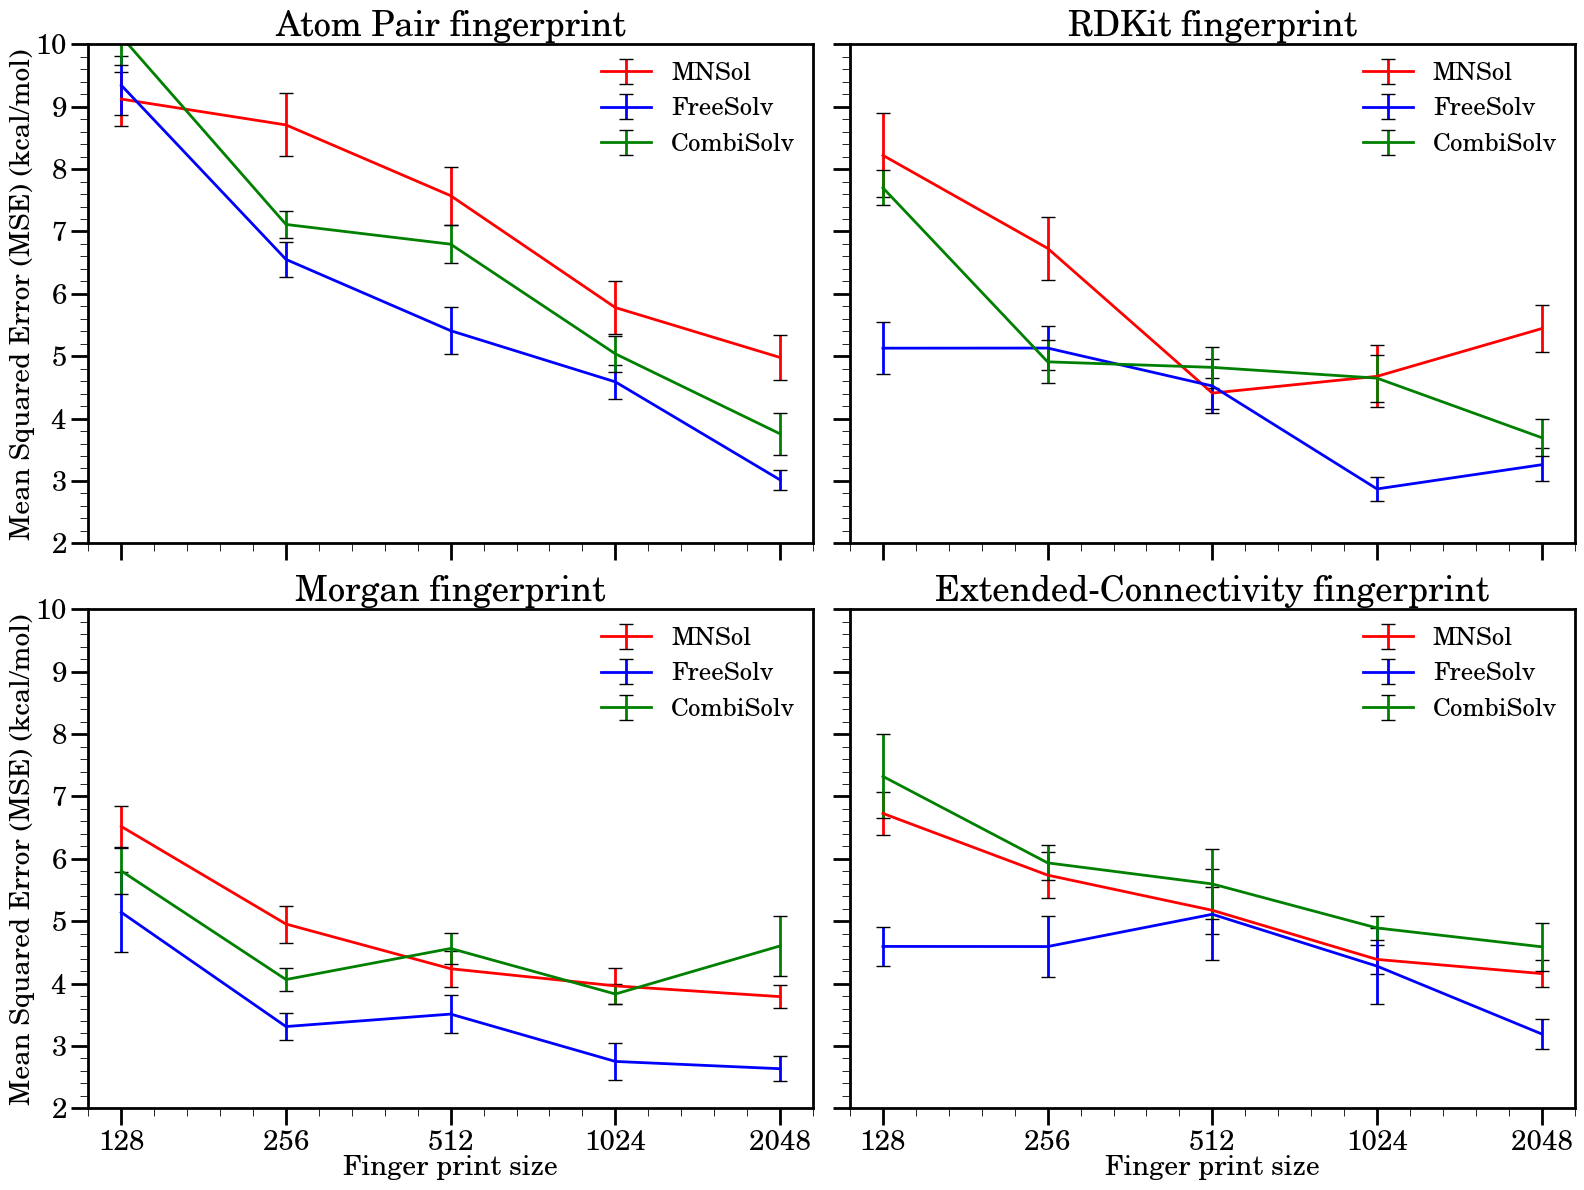

In [17]:
dimensions = [128, 256, 512, 1024, 2048]
results_dict = {
    128: results_128,
    256: results_256,
    512: results_512,
    1024: results_1024,
    2048: results_2048
}

#"xgb" = XGBRegressor()

ap_mnsol_scores = evaluate_model_with_different_dimensions(results_dict, mnsol_target, "xgb", "mnsol_ap")
ap_fsol_scores = evaluate_model_with_different_dimensions(results_dict, fsol_target, "xgb", "fsol_ap")
ap_csol_scores = evaluate_model_with_different_dimensions(results_dict, csol_target, "xgb", "csol_ap")

rdk_mnsol_scores = evaluate_model_with_different_dimensions(results_dict, mnsol_target, "xgb", "mnsol_rdk")
rdk_fsol_scores = evaluate_model_with_different_dimensions(results_dict, fsol_target, "xgb", "fsol_rdk")
rdk_csol_scores = evaluate_model_with_different_dimensions(results_dict, csol_target, "xgb", "csol_rdk")

morgan_mnsol_scores = evaluate_model_with_different_dimensions(results_dict, mnsol_target, "xgb", "mnsol_morgan")
morgan_fsol_scores = evaluate_model_with_different_dimensions(results_dict, fsol_target, "xgb", "fsol_morgan")
morgan_csol_scores = evaluate_model_with_different_dimensions(results_dict, csol_target, "xgb", "csol_morgan")

ecfp_mnsol_scores = evaluate_model_with_different_dimensions(results_dict, mnsol_target, "xgb", "mnsol_ecfp")
ecfp_fsol_scores = evaluate_model_with_different_dimensions(results_dict, fsol_target, "xgb", "fsol_ecfp")
ecfp_csol_scores = evaluate_model_with_different_dimensions(results_dict, csol_target, "xgb", "csol_ecfp")

fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
dimensions = [128, 256, 512, 1024, 2048]
xticks = np.arange(len(dimensions))

# AP plot
ap_mse_means_mnsol = [ap_mnsol_scores[dim]['mse_mean'] for dim in dimensions]
ap_mse_means_fsol = [ap_fsol_scores[dim]['mse_mean'] for dim in dimensions]
ap_mse_means_csol = [ap_csol_scores[dim]['mse_mean'] for dim in dimensions]
ap_mse_stds_mnsol = [ap_mnsol_scores[dim]['mse_std'] for dim in dimensions]
ap_mse_stds_fsol = [ap_fsol_scores[dim]['mse_std'] for dim in dimensions]
ap_mse_stds_csol = [ap_csol_scores[dim]['mse_std'] for dim in dimensions]
axs[0, 0].errorbar(xticks, ap_mse_means_mnsol, yerr=ap_mse_stds_mnsol, color='red', label='MNSol',  capsize=5)
axs[0, 0].errorbar(xticks, ap_mse_means_fsol, yerr=ap_mse_stds_fsol, color='blue', label='FreeSolv',  capsize=5)
axs[0, 0].errorbar(xticks, ap_mse_means_csol, yerr=ap_mse_stds_csol, color='green', label='CombiSolv',  capsize=5)
axs[0, 0].set_title('Atom Pair fingerprint', loc = "center", fontsize = 25)
#axs[0, 0].set_xlabel('Finger print size', fontsize = 20)
axs[0, 0].set_ylabel('Mean Squared Error (MSE) (kcal/mol)', fontsize = 20)
axs[0, 0].legend(fontsize = 18)
axs[0, 0].set_xticks(xticks)
axs[0, 0].set_xticklabels(dimensions)

# RDK plot
rdk_mse_means_mnsol = [rdk_mnsol_scores[dim]['mse_mean'] for dim in dimensions]
rdk_mse_means_fsol = [rdk_fsol_scores[dim]['mse_mean'] for dim in dimensions]
rdk_mse_means_csol = [rdk_csol_scores[dim]['mse_mean'] for dim in dimensions]
rdk_mse_stds_mnsol = [rdk_mnsol_scores[dim]['mse_std'] for dim in dimensions]
rdk_mse_stds_fsol = [rdk_fsol_scores[dim]['mse_std'] for dim in dimensions]
rdk_mse_stds_csol = [rdk_csol_scores[dim]['mse_std'] for dim in dimensions]
axs[0, 1].errorbar(xticks, rdk_mse_means_mnsol, yerr=rdk_mse_stds_mnsol, color='red', label='MNSol',  capsize=5)
axs[0, 1].errorbar(xticks, rdk_mse_means_fsol, yerr=rdk_mse_stds_fsol, color='blue', label='FreeSolv',  capsize=5)
axs[0, 1].errorbar(xticks, rdk_mse_means_csol, yerr=rdk_mse_stds_csol, color='green', label='CombiSolv',  capsize=5)
axs[0, 1].set_title('RDKit fingerprint', loc = "center", fontsize = 25)
#axs[0, 1].set_xlabel('Finger print size', fontsize = 20)
#axs[0, 1].set_ylabel('Mean Squared Error (MSE) (kcal/mol)', fontsize = 20)
axs[0, 1].legend(fontsize = 18)
axs[0, 1].set_xticks(xticks)
axs[0, 1].set_xticklabels(dimensions)

# Morgan plot
morgan_mse_means_mnsol = [morgan_mnsol_scores[dim]['mse_mean'] for dim in dimensions]
morgan_mse_means_fsol = [morgan_fsol_scores[dim]['mse_mean'] for dim in dimensions]
morgan_mse_means_csol = [morgan_csol_scores[dim]['mse_mean'] for dim in dimensions]
morgan_mse_stds_mnsol = [morgan_mnsol_scores[dim]['mse_std'] for dim in dimensions]
morgan_mse_stds_fsol = [morgan_fsol_scores[dim]['mse_std'] for dim in dimensions]
morgan_mse_stds_csol = [morgan_csol_scores[dim]['mse_std'] for dim in dimensions]
axs[1, 0].errorbar(xticks, morgan_mse_means_mnsol, yerr=morgan_mse_stds_mnsol, color='red', label='MNSol',  capsize=5)
axs[1, 0].errorbar(xticks, morgan_mse_means_fsol, yerr=morgan_mse_stds_fsol, color='blue', label='FreeSolv',  capsize=5)
axs[1, 0].errorbar(xticks, morgan_mse_means_csol, yerr=morgan_mse_stds_csol, color='green', label='CombiSolv',  capsize=5)
axs[1, 0].set_title('Morgan fingerprint', loc = "center", fontsize = 25)
axs[1, 0].set_xlabel('Finger print size', fontsize = 20)
axs[1, 0].set_ylabel('Mean Squared Error (MSE) (kcal/mol)', fontsize = 20)
axs[1, 0].legend(fontsize = 18)
axs[1, 0].set_xticks(xticks)
axs[1, 0].set_xticklabels(dimensions)

# ECFP plot
ecfp_mse_means_mnsol = [ecfp_mnsol_scores[dim]['mse_mean'] for dim in dimensions]
ecfp_mse_means_fsol = [ecfp_fsol_scores[dim]['mse_mean'] for dim in dimensions]
ecfp_mse_means_csol = [ecfp_csol_scores[dim]['mse_mean'] for dim in dimensions]
ecfp_mse_stds_mnsol = [ecfp_mnsol_scores[dim]['mse_std'] for dim in dimensions]
ecfp_mse_stds_fsol = [ecfp_fsol_scores[dim]['mse_std'] for dim in dimensions]
ecfp_mse_stds_csol = [ecfp_csol_scores[dim]['mse_std'] for dim in dimensions]
axs[1, 1].errorbar(xticks, ecfp_mse_means_mnsol, yerr=ecfp_mse_stds_mnsol, color='red', label='MNSol',  capsize=5)
axs[1, 1].errorbar(xticks, ecfp_mse_means_fsol, yerr=ecfp_mse_stds_fsol, color='blue', label='FreeSolv',  capsize=5)
axs[1, 1].errorbar(xticks, ecfp_mse_means_csol, yerr=ecfp_mse_stds_csol, color='green', label='CombiSolv',  capsize=5)
axs[1, 1].set_title('Extended-Connectivity fingerprint', loc = "center", fontsize = 25)
axs[1, 1].set_xlabel('Finger print size', fontsize = 20)
#axs[1, 1].set_ylabel('Mean Squared Error (MSE) (kcal/mol)', fontsize = 20)
axs[1, 1].legend(fontsize = 18)
axs[1, 1].set_xticks(xticks)
axs[1, 1].set_xticklabels(dimensions)
axs[1, 1].set_ylim(2, 10)
plt.tight_layout()
plt.show()

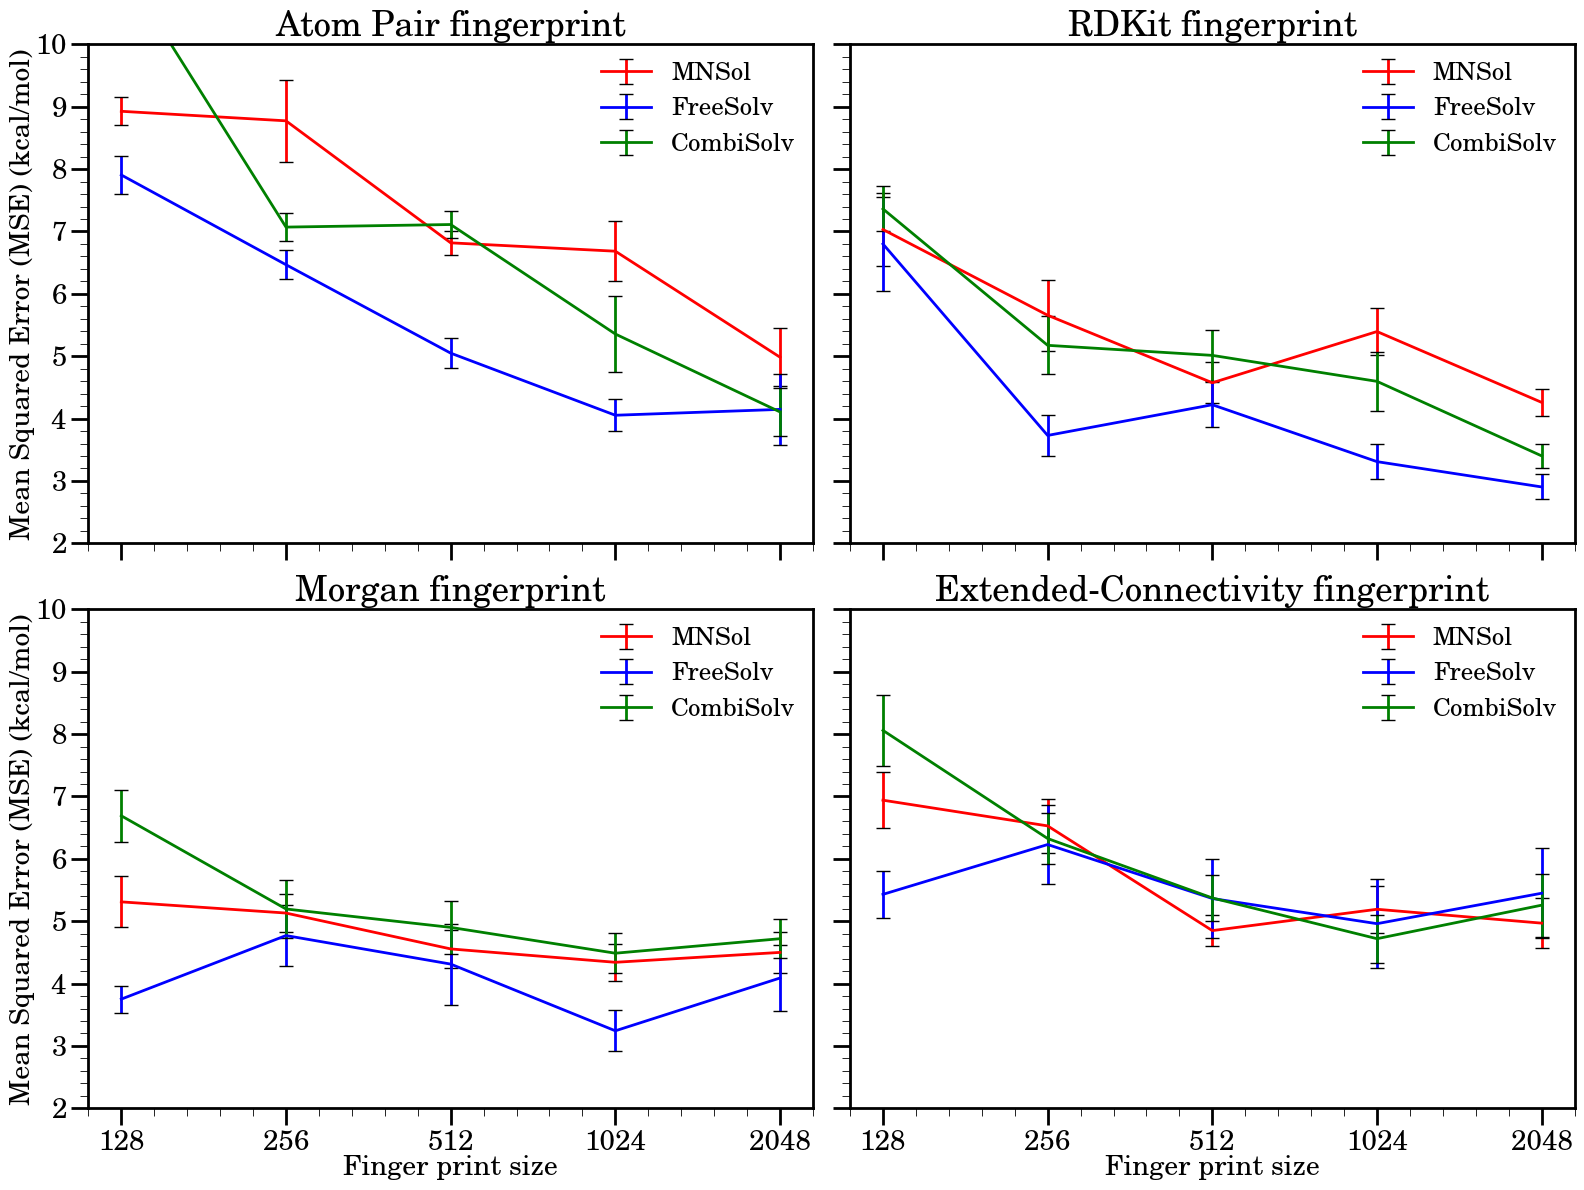

In [18]:
dimensions = [128, 256, 512, 1024, 2048]
results_dict = {
    128: results_128,
    256: results_256,
    512: results_512,
    1024: results_1024,
    2048: results_2048
}

rfr_model = RandomForestRegressor()

ap_mnsol_scores = evaluate_model_with_different_dimensions(results_dict, mnsol_target, rfr_model, "mnsol_ap")
ap_fsol_scores = evaluate_model_with_different_dimensions(results_dict, fsol_target, rfr_model, "fsol_ap")
ap_csol_scores = evaluate_model_with_different_dimensions(results_dict, csol_target, rfr_model, "csol_ap")

rdk_mnsol_scores = evaluate_model_with_different_dimensions(results_dict, mnsol_target, rfr_model, "mnsol_rdk")
rdk_fsol_scores = evaluate_model_with_different_dimensions(results_dict, fsol_target, rfr_model, "fsol_rdk")
rdk_csol_scores = evaluate_model_with_different_dimensions(results_dict, csol_target, rfr_model, "csol_rdk")

morgan_mnsol_scores = evaluate_model_with_different_dimensions(results_dict, mnsol_target, rfr_model, "mnsol_morgan")
morgan_fsol_scores = evaluate_model_with_different_dimensions(results_dict, fsol_target, rfr_model, "fsol_morgan")
morgan_csol_scores = evaluate_model_with_different_dimensions(results_dict, csol_target, rfr_model, "csol_morgan")

ecfp_mnsol_scores = evaluate_model_with_different_dimensions(results_dict, mnsol_target, rfr_model, "mnsol_ecfp")
ecfp_fsol_scores = evaluate_model_with_different_dimensions(results_dict, fsol_target, rfr_model, "fsol_ecfp")
ecfp_csol_scores = evaluate_model_with_different_dimensions(results_dict, csol_target, rfr_model, "csol_ecfp")

fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
dimensions = [128, 256, 512, 1024, 2048]
xticks = np.arange(len(dimensions))

# AP plot
ap_mse_means_mnsol = [ap_mnsol_scores[dim]['mse_mean'] for dim in dimensions]
ap_mse_means_fsol = [ap_fsol_scores[dim]['mse_mean'] for dim in dimensions]
ap_mse_means_csol = [ap_csol_scores[dim]['mse_mean'] for dim in dimensions]
ap_mse_stds_mnsol = [ap_mnsol_scores[dim]['mse_std'] for dim in dimensions]
ap_mse_stds_fsol = [ap_fsol_scores[dim]['mse_std'] for dim in dimensions]
ap_mse_stds_csol = [ap_csol_scores[dim]['mse_std'] for dim in dimensions]
axs[0, 0].errorbar(xticks, ap_mse_means_mnsol, yerr=ap_mse_stds_mnsol, color='red', label='MNSol',  capsize=5)
axs[0, 0].errorbar(xticks, ap_mse_means_fsol, yerr=ap_mse_stds_fsol, color='blue', label='FreeSolv',  capsize=5)
axs[0, 0].errorbar(xticks, ap_mse_means_csol, yerr=ap_mse_stds_csol, color='green', label='CombiSolv',  capsize=5)
axs[0, 0].set_title('Atom Pair fingerprint', loc = "center", fontsize = 25)
#axs[0, 0].set_xlabel('Finger print size', fontsize = 20)
axs[0, 0].set_ylabel('Mean Squared Error (MSE) (kcal/mol)', fontsize = 20)
axs[0, 0].legend(fontsize = 18)
axs[0, 0].set_xticks(xticks)
axs[0, 0].set_xticklabels(dimensions)

# RDK plot
rdk_mse_means_mnsol = [rdk_mnsol_scores[dim]['mse_mean'] for dim in dimensions]
rdk_mse_means_fsol = [rdk_fsol_scores[dim]['mse_mean'] for dim in dimensions]
rdk_mse_means_csol = [rdk_csol_scores[dim]['mse_mean'] for dim in dimensions]
rdk_mse_stds_mnsol = [rdk_mnsol_scores[dim]['mse_std'] for dim in dimensions]
rdk_mse_stds_fsol = [rdk_fsol_scores[dim]['mse_std'] for dim in dimensions]
rdk_mse_stds_csol = [rdk_csol_scores[dim]['mse_std'] for dim in dimensions]
axs[0, 1].errorbar(xticks, rdk_mse_means_mnsol, yerr=rdk_mse_stds_mnsol, color='red', label='MNSol',  capsize=5)
axs[0, 1].errorbar(xticks, rdk_mse_means_fsol, yerr=rdk_mse_stds_fsol, color='blue', label='FreeSolv',  capsize=5)
axs[0, 1].errorbar(xticks, rdk_mse_means_csol, yerr=rdk_mse_stds_csol, color='green', label='CombiSolv',  capsize=5)
axs[0, 1].set_title('RDKit fingerprint', loc = "center", fontsize = 25)
#axs[0, 1].set_xlabel('Finger print size', fontsize = 20)
#axs[0, 1].set_ylabel('Mean Squared Error (MSE) (kcal/mol)', fontsize = 20)
axs[0, 1].legend(fontsize = 18)
axs[0, 1].set_xticks(xticks)
axs[0, 1].set_xticklabels(dimensions)

# Morgan plot
morgan_mse_means_mnsol = [morgan_mnsol_scores[dim]['mse_mean'] for dim in dimensions]
morgan_mse_means_fsol = [morgan_fsol_scores[dim]['mse_mean'] for dim in dimensions]
morgan_mse_means_csol = [morgan_csol_scores[dim]['mse_mean'] for dim in dimensions]
morgan_mse_stds_mnsol = [morgan_mnsol_scores[dim]['mse_std'] for dim in dimensions]
morgan_mse_stds_fsol = [morgan_fsol_scores[dim]['mse_std'] for dim in dimensions]
morgan_mse_stds_csol = [morgan_csol_scores[dim]['mse_std'] for dim in dimensions]
axs[1, 0].errorbar(xticks, morgan_mse_means_mnsol, yerr=morgan_mse_stds_mnsol, color='red', label='MNSol',  capsize=5)
axs[1, 0].errorbar(xticks, morgan_mse_means_fsol, yerr=morgan_mse_stds_fsol, color='blue', label='FreeSolv',  capsize=5)
axs[1, 0].errorbar(xticks, morgan_mse_means_csol, yerr=morgan_mse_stds_csol, color='green', label='CombiSolv',  capsize=5)
axs[1, 0].set_title('Morgan fingerprint', loc = "center", fontsize = 25)
axs[1, 0].set_xlabel('Finger print size', fontsize = 20)
axs[1, 0].set_ylabel('Mean Squared Error (MSE) (kcal/mol)', fontsize = 20)
axs[1, 0].legend(fontsize = 18)
axs[1, 0].set_xticks(xticks)
axs[1, 0].set_xticklabels(dimensions)

# ECFP plot
ecfp_mse_means_mnsol = [ecfp_mnsol_scores[dim]['mse_mean'] for dim in dimensions]
ecfp_mse_means_fsol = [ecfp_fsol_scores[dim]['mse_mean'] for dim in dimensions]
ecfp_mse_means_csol = [ecfp_csol_scores[dim]['mse_mean'] for dim in dimensions]
ecfp_mse_stds_mnsol = [ecfp_mnsol_scores[dim]['mse_std'] for dim in dimensions]
ecfp_mse_stds_fsol = [ecfp_fsol_scores[dim]['mse_std'] for dim in dimensions]
ecfp_mse_stds_csol = [ecfp_csol_scores[dim]['mse_std'] for dim in dimensions]
axs[1, 1].errorbar(xticks, ecfp_mse_means_mnsol, yerr=ecfp_mse_stds_mnsol, color='red', label='MNSol',  capsize=5)
axs[1, 1].errorbar(xticks, ecfp_mse_means_fsol, yerr=ecfp_mse_stds_fsol, color='blue', label='FreeSolv',  capsize=5)
axs[1, 1].errorbar(xticks, ecfp_mse_means_csol, yerr=ecfp_mse_stds_csol, color='green', label='CombiSolv',  capsize=5)
axs[1, 1].set_title('Extended-Connectivity fingerprint', loc = "center", fontsize = 25)
axs[1, 1].set_xlabel('Finger print size', fontsize = 20)
#axs[1, 1].set_ylabel('Mean Squared Error (MSE) (kcal/mol)', fontsize = 20)
axs[1, 1].legend(fontsize = 18)
axs[1, 1].set_xticks(xticks)
axs[1, 1].set_xticklabels(dimensions)
axs[1, 1].set_ylim(2, 10)
plt.tight_layout()
plt.show()

In [22]:
xgb_model = XGBRegressor()
rfr_model = RandomForestRegressor()
X = results_2048['mnsol_ap']
X = fsol_pubchem
y = fsol_target

indices_to_remove = [246, 248, 250, 251, 252, 253, 309, 369]
mnsol_pubchem_cure = np.delete(mnsol_pubchem, indices_to_remove, axis=0)
mnsol_target_cure = np.delete(mnsol_target, indices_to_remove, axis=0)

indices_to_remove = [205, 433, 631]
fsol_pubchem_cure = np.delete(fsol_pubchem, indices_to_remove, axis=0)
fsol_target_cure = np.delete(fsol_target, indices_to_remove, axis=0)

indices_to_remove = [816, 1140]
csol_pubchem_cure = np.delete(csol_pubchem, indices_to_remove, axis=0)
csol_target_cure = np.delete(csol_target, indices_to_remove, axis=0)

In [23]:
## RFR model
scores_rfr_pubchem_mnsol = cross_validate_model(mnsol_pubchem_cure, mnsol_target_cure, rfr_model)
scores_rfr_pubchem_fsol = cross_validate_model(fsol_pubchem_cure, fsol_target_cure, rfr_model)
scores_rfr_pubchem_csol = cross_validate_model(csol_pubchem_cure, csol_target_cure, rfr_model)

scores_rfr_maccs_mnsol = cross_validate_model(mnsol_maccs, mnsol_target, rfr_model)
scores_rfr_maccs_fsol = cross_validate_model(fsol_maccs, fsol_target, rfr_model)
scores_rfr_maccs_csol = cross_validate_model(csol_maccs, csol_target, rfr_model)

In [24]:
## XGB model
scores_xgb_pubchem_mnsol = cross_validate_model(mnsol_pubchem_cure, mnsol_target_cure, xgb_model)
scores_xgb_pubchem_fsol = cross_validate_model(fsol_pubchem_cure, fsol_target_cure, xgb_model)
scores_xgb_pubchem_csol = cross_validate_model(csol_pubchem_cure, csol_target_cure, xgb_model)

scores_xgb_maccs_mnsol = cross_validate_model(mnsol_maccs, mnsol_target, xgb_model)
scores_xgb_maccs_fsol = cross_validate_model(fsol_maccs, fsol_target, xgb_model)
scores_xgb_maccs_csol = cross_validate_model(csol_maccs, csol_target, xgb_model)

In [25]:
scores_xgb_ecfp_mnsol = cross_validate_model(results_2048['mnsol_ecfp'], mnsol_target,xgb_model)
scores_xgb_ecfp_fsol = cross_validate_model(results_2048['fsol_ecfp'], fsol_target,xgb_model)
scores_xgb_ecfp_csol = cross_validate_model(results_2048['csol_ecfp'], csol_target,xgb_model)

scores_xgb_morgan_mnsol = cross_validate_model(results_2048['mnsol_morgan'], mnsol_target,xgb_model)
scores_xgb_morgan_fsol = cross_validate_model(results_2048['fsol_morgan'], fsol_target,xgb_model)
scores_xgb_morgan_csol = cross_validate_model(results_2048['csol_morgan'], csol_target,xgb_model)

scores_xgb_rdk_mnsol = cross_validate_model(results_2048['mnsol_rdk'], mnsol_target,xgb_model)
scores_xgb_rdk_fsol = cross_validate_model(results_2048['fsol_rdk'], fsol_target,xgb_model)
scores_xgb_rdk_csol = cross_validate_model(results_2048['csol_rdk'], csol_target,xgb_model)

scores_xgb_ap_mnsol = cross_validate_model(results_2048['mnsol_ap'], mnsol_target,xgb_model)
scores_xgb_ap_fsol = cross_validate_model(results_2048['fsol_ap'], fsol_target,xgb_model)
scores_xgb_ap_csol = cross_validate_model(results_2048['csol_ap'], csol_target,xgb_model)


In [26]:
scores_rfr_ecfp_mnsol = cross_validate_model(results_2048['mnsol_ecfp'], mnsol_target,rfr_model)
scores_rfr_ecfp_fsol = cross_validate_model(results_2048['fsol_ecfp'], fsol_target,rfr_model)
scores_rfr_ecfp_csol = cross_validate_model(results_2048['csol_ecfp'], csol_target,rfr_model)

scores_rfr_morgan_mnsol = cross_validate_model(results_2048['mnsol_morgan'], mnsol_target,rfr_model)
scores_rfr_morgan_fsol = cross_validate_model(results_2048['fsol_morgan'], fsol_target,rfr_model)
scores_rfr_morgan_csol = cross_validate_model(results_2048['csol_morgan'], csol_target,rfr_model)

scores_rfr_rdk_mnsol = cross_validate_model(results_2048['mnsol_rdk'], mnsol_target,rfr_model)
scores_rfr_rdk_fsol = cross_validate_model(results_2048['fsol_rdk'], fsol_target,rfr_model)
scores_rfr_rdk_csol = cross_validate_model(results_2048['csol_rdk'], csol_target,rfr_model)

scores_rfr_ap_mnsol = cross_validate_model(results_2048['mnsol_ap'], mnsol_target,rfr_model)
scores_rfr_ap_fsol = cross_validate_model(results_2048['fsol_ap'], fsol_target,rfr_model)
scores_rfr_ap_csol = cross_validate_model(results_2048['csol_ap'], csol_target,rfr_model)

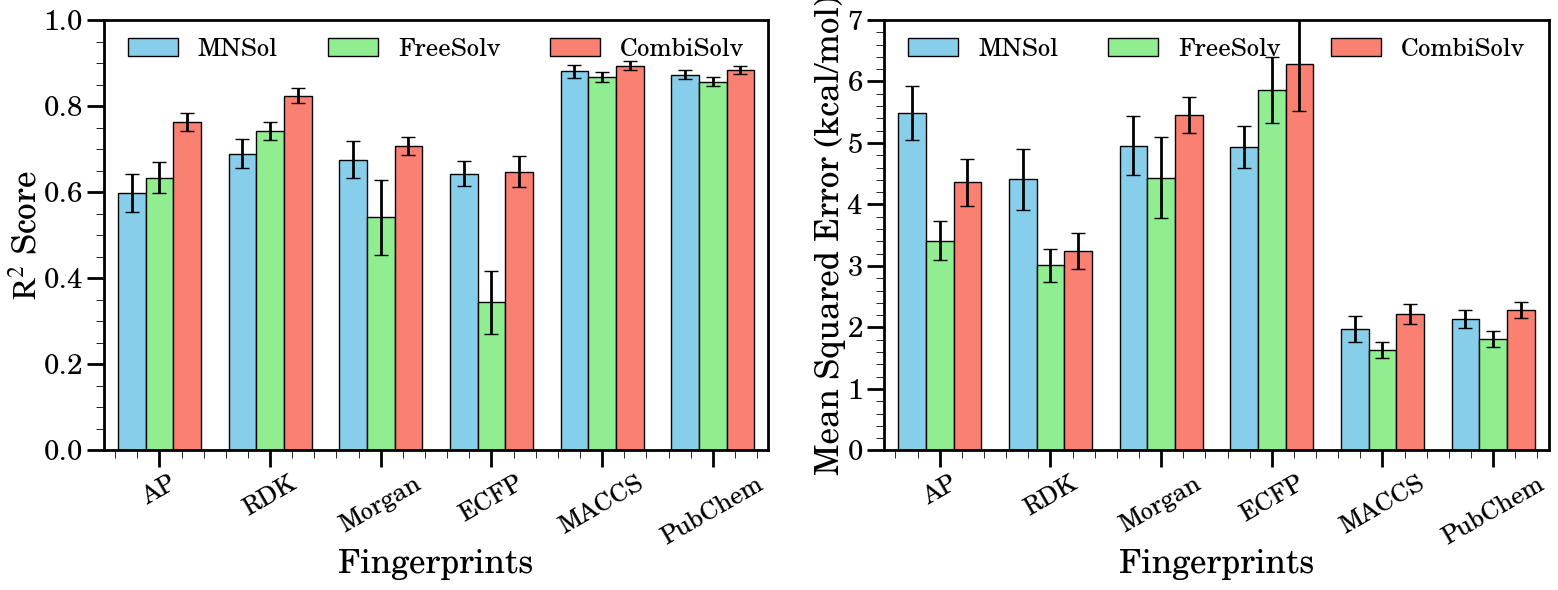

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# Data for the plot
representations = ['AP', 'RDK', 'Morgan', 'ECFP', "MACCS", "PubChem"]
mnsol_means = [
    np.mean(scores_rfr_ap_mnsol[:, 0]),
    np.mean(scores_rfr_rdk_mnsol[:, 0]),
    np.mean(scores_rfr_morgan_mnsol[:, 0]),
    np.mean(scores_rfr_ecfp_mnsol[:, 0]),
    np.mean(scores_rfr_maccs_mnsol[:, 0]),
    np.mean(scores_rfr_pubchem_mnsol[:, 0]),
]
fsol_means = [
    np.mean(scores_rfr_ap_fsol[:, 0]),
    np.mean(scores_rfr_rdk_fsol[:, 0]),
    np.mean(scores_rfr_morgan_fsol[:, 0]),
    np.mean(scores_rfr_ecfp_fsol[:, 0]),
    np.mean(scores_rfr_maccs_fsol[:, 0]),
    np.mean(scores_rfr_pubchem_fsol[:, 0]),

]
csol_means = [
    np.mean(scores_rfr_ap_csol[:, 0]),
    np.mean(scores_rfr_rdk_csol[:, 0]),
    np.mean(scores_rfr_morgan_csol[:, 0]),
    np.mean(scores_rfr_ecfp_csol[:, 0]),
    np.mean(scores_rfr_maccs_csol[:, 0]),
    np.mean(scores_rfr_pubchem_csol[:, 0]),

]
mnsol_stds = [
    np.std(scores_rfr_ap_mnsol[:, 0]),
    np.std(scores_rfr_rdk_mnsol[:, 0]),
    np.std(scores_rfr_morgan_mnsol[:, 0]),
    np.std(scores_rfr_ecfp_mnsol[:, 0]),
    np.std(scores_rfr_maccs_mnsol[:, 0]),
    np.std(scores_rfr_pubchem_mnsol[:, 0]),
]
fsol_stds = [
    np.std(scores_rfr_ap_fsol[:, 0]),
    np.std(scores_rfr_rdk_fsol[:, 0]),
    np.std(scores_rfr_morgan_fsol[:, 0]),
    np.std(scores_rfr_ecfp_fsol[:, 0]),
    np.std(scores_rfr_maccs_fsol[:, 0]),
    np.std(scores_rfr_pubchem_fsol[:, 0]),
]
csol_stds = [
    np.std(scores_rfr_ap_csol[:, 0]),
    np.std(scores_rfr_rdk_csol[:, 0]),
    np.std(scores_rfr_morgan_csol[:, 0]),
    np.std(scores_rfr_ecfp_csol[:, 0]),
    np.std(scores_rfr_maccs_csol[:, 0]),
    np.std(scores_rfr_pubchem_fsol[:, 0]),
]
mnsol_stds = np.array(mnsol_stds) / np.sqrt(10)
fsol_stds = np.array(fsol_stds) / np.sqrt(10)
csol_stds = np.array(csol_stds) / np.sqrt(10)

bar_width = 0.25
x = np.arange(len(representations))

bars1 = ax[0].bar(x - bar_width, mnsol_means, bar_width, yerr=mnsol_stds, capsize=5, label='MNSol', color='skyblue', edgecolor='black', lw = 1.)
bars2 = ax[0].bar(x, fsol_means, bar_width, yerr=fsol_stds, capsize=5, label='FreeSolv', color='lightgreen', edgecolor='black', lw = 1)
bars3 = ax[0].bar(x + bar_width, csol_means, bar_width, yerr=csol_stds, capsize=5, label='CombiSolv', color='salmon', edgecolor='black', lw = 1)

# Add labels and title
ax[0].set_xlabel('Fingerprints', fontsize=24)
ax[0].set_ylabel(r'$\rm R^2$ Score', fontsize=24)
ax[0].set_xticks(x)
ax[0].set_xlim(-0.5, 5.5)
ax[0].set_xticklabels(representations, rotation=30, ha='center', fontsize=18)
ax[0].legend(ncols = 3, fontsize = 18, loc = "upper center")

# Data for the plot
representations = ['AP', 'RDK', 'Morgan', 'ECFP', "MACCS", "PubChem"]
mnsol_means = [
    np.mean(scores_rfr_ap_mnsol[:, 1]),
    np.mean(scores_rfr_rdk_mnsol[:, 1]),
    np.mean(scores_rfr_morgan_mnsol[:, 1]),
    np.mean(scores_rfr_ecfp_mnsol[:, 1]),
    np.mean(scores_rfr_maccs_mnsol[:, 1]),
    np.mean(scores_rfr_pubchem_mnsol[:, 1]),
]
fsol_means = [
    np.mean(scores_rfr_ap_fsol[:, 1]),
    np.mean(scores_rfr_rdk_fsol[:, 1]),
    np.mean(scores_rfr_morgan_fsol[:, 1]),
    np.mean(scores_rfr_ecfp_fsol[:, 1]),
    np.mean(scores_rfr_maccs_fsol[:, 1]),
    np.mean(scores_rfr_pubchem_fsol[:, 1]),

]
csol_means = [
    np.mean(scores_rfr_ap_csol[:, 1]),
    np.mean(scores_rfr_rdk_csol[:, 1]),
    np.mean(scores_rfr_morgan_csol[:, 1]),
    np.mean(scores_rfr_ecfp_csol[:, 1]),
    np.mean(scores_rfr_maccs_csol[:, 1]),
    np.mean(scores_rfr_pubchem_csol[:, 1]),

]
mnsol_stds = [
    np.std(scores_rfr_ap_mnsol[:, 1]),
    np.std(scores_rfr_rdk_mnsol[:, 1]),
    np.std(scores_rfr_morgan_mnsol[:, 1]),
    np.std(scores_rfr_ecfp_mnsol[:, 1]),
    np.std(scores_rfr_maccs_mnsol[:, 1]),
    np.std(scores_rfr_pubchem_mnsol[:, 1]),
]
fsol_stds = [
    np.std(scores_rfr_ap_fsol[:, 1]),
    np.std(scores_rfr_rdk_fsol[:, 1]),
    np.std(scores_rfr_morgan_fsol[:, 1]),
    np.std(scores_rfr_ecfp_fsol[:, 1]),
    np.std(scores_rfr_maccs_fsol[:, 1]),
    np.std(scores_rfr_pubchem_fsol[:, 1]),
]
csol_stds = [
    np.std(scores_rfr_ap_csol[:, 1]),
    np.std(scores_rfr_rdk_csol[:, 1]),
    np.std(scores_rfr_morgan_csol[:, 1]),
    np.std(scores_rfr_ecfp_csol[:, 1]),
    np.std(scores_rfr_maccs_csol[:, 1]),
    np.std(scores_rfr_pubchem_fsol[:, 1]),
]
mnsol_stds = np.array(mnsol_stds) / np.sqrt(10)
fsol_stds = np.array(fsol_stds) / np.sqrt(10)
csol_stds = np.array(csol_stds) / np.sqrt(10)

# Create the bar plot
bar_width = 0.25
x = np.arange(len(representations))

bars1 = ax[1].bar(x - bar_width, mnsol_means, bar_width, yerr=mnsol_stds, capsize=5, label='MNSol', color='skyblue', edgecolor='black', lw = 1.)
bars2 = ax[1].bar(x, fsol_means, bar_width, yerr=fsol_stds, capsize=5, label='FreeSolv', color='lightgreen', edgecolor='black', lw = 1)
bars3 = ax[1].bar(x + bar_width, csol_means, bar_width, yerr=csol_stds, capsize=5, label='CombiSolv', color='salmon', edgecolor='black', lw = 1)

# Add labels and title
ax[1].set_xlabel('Fingerprints', fontsize=24)
ax[1].set_ylabel(r'Mean Squared Error (kcal/mol)', fontsize=24)
#ax.set_title('Comparison of Different Representations (Mean R2 Score with Std Error)', fontsize=16)
ax[1].set_xticks(x)
ax[1].set_xlim(-0.5, 5.5)
ax[1].set_ylim(0, 7.)
ax[1].set_xticklabels(representations, rotation=30, ha='center', fontsize=18)
ax[1].legend(ncols = 3, fontsize = 18, loc = "upper center")


fig.tight_layout()
#plt.savefig("Comparison_of_fingerprints_rfr.png")

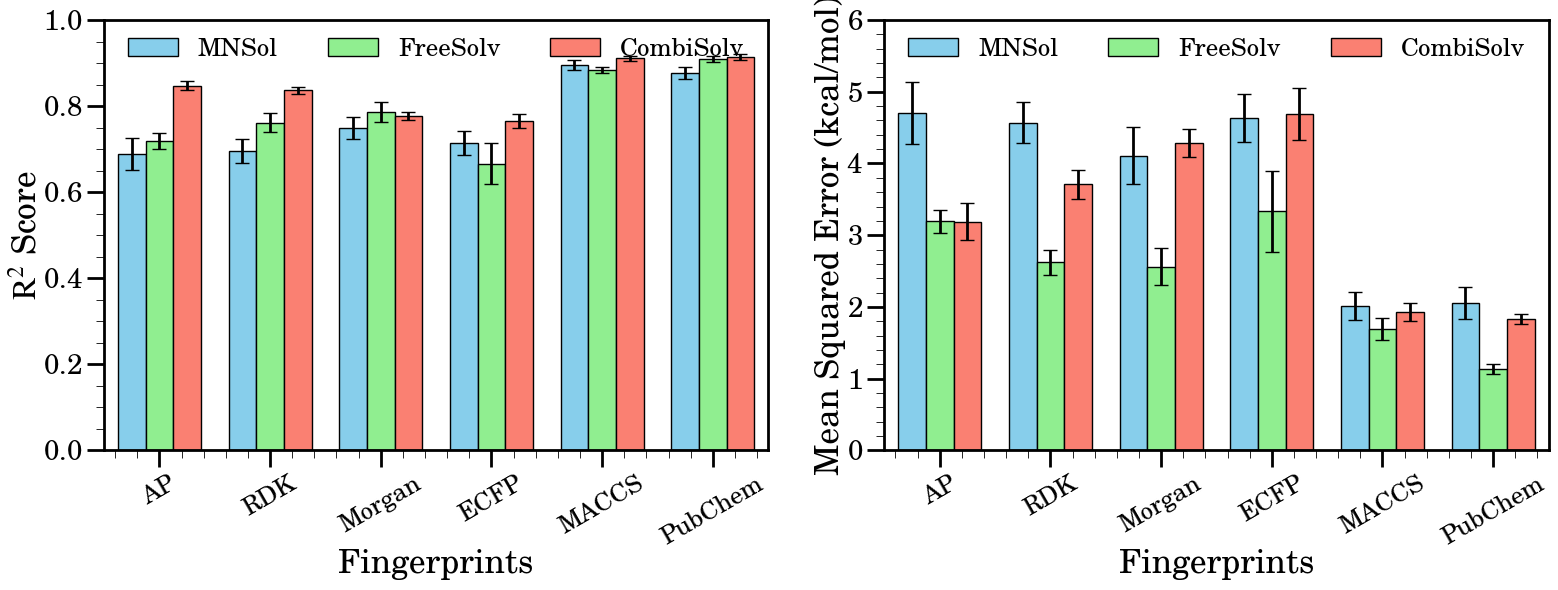

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# Data for the plot
representations = ['AP', 'RDK', 'Morgan', 'ECFP', "MACCS", "PubChem"]
mnsol_means = [
    np.mean(scores_xgb_ap_mnsol[:, 0]),
    np.mean(scores_xgb_rdk_mnsol[:, 0]),
    np.mean(scores_xgb_morgan_mnsol[:, 0]),
    np.mean(scores_xgb_ecfp_mnsol[:, 0]),
    np.mean(scores_xgb_maccs_mnsol[:, 0]),
    np.mean(scores_xgb_pubchem_mnsol[:, 0]),
]
fsol_means = [
    np.mean(scores_xgb_ap_fsol[:, 0]),
    np.mean(scores_xgb_rdk_fsol[:, 0]),
    np.mean(scores_xgb_morgan_fsol[:, 0]),
    np.mean(scores_xgb_ecfp_fsol[:, 0]),
    np.mean(scores_xgb_maccs_fsol[:, 0]),
    np.mean(scores_xgb_pubchem_fsol[:, 0]),

]
csol_means = [
    np.mean(scores_xgb_ap_csol[:, 0]),
    np.mean(scores_xgb_rdk_csol[:, 0]),
    np.mean(scores_xgb_morgan_csol[:, 0]),
    np.mean(scores_xgb_ecfp_csol[:, 0]),
    np.mean(scores_xgb_maccs_csol[:, 0]),
    np.mean(scores_xgb_pubchem_csol[:, 0]),

]
mnsol_stds = [
    np.std(scores_xgb_ap_mnsol[:, 0]),
    np.std(scores_xgb_rdk_mnsol[:, 0]),
    np.std(scores_xgb_morgan_mnsol[:, 0]),
    np.std(scores_xgb_ecfp_mnsol[:, 0]),
    np.std(scores_xgb_maccs_mnsol[:, 0]),
    np.std(scores_xgb_pubchem_mnsol[:, 0]),
]
fsol_stds = [
    np.std(scores_xgb_ap_fsol[:, 0]),
    np.std(scores_xgb_rdk_fsol[:, 0]),
    np.std(scores_xgb_morgan_fsol[:, 0]),
    np.std(scores_xgb_ecfp_fsol[:, 0]),
    np.std(scores_xgb_maccs_fsol[:, 0]),
    np.std(scores_xgb_pubchem_fsol[:, 0]),
]
csol_stds = [
    np.std(scores_xgb_ap_csol[:, 0]),
    np.std(scores_xgb_rdk_csol[:, 0]),
    np.std(scores_xgb_morgan_csol[:, 0]),
    np.std(scores_xgb_ecfp_csol[:, 0]),
    np.std(scores_xgb_maccs_csol[:, 0]),
    np.std(scores_xgb_pubchem_fsol[:, 0]),
]
mnsol_stds = np.array(mnsol_stds) / np.sqrt(10)
fsol_stds = np.array(fsol_stds) / np.sqrt(10)
csol_stds = np.array(csol_stds) / np.sqrt(10)

bar_width = 0.25
x = np.arange(len(representations))

bars1 = ax[0].bar(x - bar_width, mnsol_means, bar_width, yerr=mnsol_stds, capsize=5, label='MNSol', color='skyblue', edgecolor='black', lw = 1.)
bars2 = ax[0].bar(x, fsol_means, bar_width, yerr=fsol_stds, capsize=5, label='FreeSolv', color='lightgreen', edgecolor='black', lw = 1)
bars3 = ax[0].bar(x + bar_width, csol_means, bar_width, yerr=csol_stds, capsize=5, label='CombiSolv', color='salmon', edgecolor='black', lw = 1)

# Add labels and title
ax[0].set_xlabel('Fingerprints', fontsize=24)
ax[0].set_ylabel(r'$\rm R^2$ Score', fontsize=24)
ax[0].set_xticks(x)
ax[0].set_xlim(-0.5, 5.5)
ax[0].set_xticklabels(representations, rotation=30, ha='center', fontsize=18)
ax[0].legend(ncols = 3, fontsize = 18, loc = "upper center")

# Data for the plot
representations = ['AP', 'RDK', 'Morgan', 'ECFP', "MACCS", "PubChem"]
mnsol_means = [
    np.mean(scores_xgb_ap_mnsol[:, 1]),
    np.mean(scores_xgb_rdk_mnsol[:, 1]),
    np.mean(scores_xgb_morgan_mnsol[:, 1]),
    np.mean(scores_xgb_ecfp_mnsol[:, 1]),
    np.mean(scores_xgb_maccs_mnsol[:, 1]),
    np.mean(scores_xgb_pubchem_mnsol[:, 1]),
]
fsol_means = [
    np.mean(scores_xgb_ap_fsol[:, 1]),
    np.mean(scores_xgb_rdk_fsol[:, 1]),
    np.mean(scores_xgb_morgan_fsol[:, 1]),
    np.mean(scores_xgb_ecfp_fsol[:, 1]),
    np.mean(scores_xgb_maccs_fsol[:, 1]),
    np.mean(scores_xgb_pubchem_fsol[:, 1]),

]
csol_means = [
    np.mean(scores_xgb_ap_csol[:, 1]),
    np.mean(scores_xgb_rdk_csol[:, 1]),
    np.mean(scores_xgb_morgan_csol[:, 1]),
    np.mean(scores_xgb_ecfp_csol[:, 1]),
    np.mean(scores_xgb_maccs_csol[:, 1]),
    np.mean(scores_xgb_pubchem_csol[:, 1]),

]
mnsol_stds = [
    np.std(scores_xgb_ap_mnsol[:, 1]),
    np.std(scores_xgb_rdk_mnsol[:, 1]),
    np.std(scores_xgb_morgan_mnsol[:, 1]),
    np.std(scores_xgb_ecfp_mnsol[:, 1]),
    np.std(scores_xgb_maccs_mnsol[:, 1]),
    np.std(scores_xgb_pubchem_mnsol[:, 1]),
]
fsol_stds = [
    np.std(scores_xgb_ap_fsol[:, 1]),
    np.std(scores_xgb_rdk_fsol[:, 1]),
    np.std(scores_xgb_morgan_fsol[:, 1]),
    np.std(scores_xgb_ecfp_fsol[:, 1]),
    np.std(scores_xgb_maccs_fsol[:, 1]),
    np.std(scores_xgb_pubchem_fsol[:, 1]),
]
csol_stds = [
    np.std(scores_xgb_ap_csol[:, 1]),
    np.std(scores_xgb_rdk_csol[:, 1]),
    np.std(scores_xgb_morgan_csol[:, 1]),
    np.std(scores_xgb_ecfp_csol[:, 1]),
    np.std(scores_xgb_maccs_csol[:, 1]),
    np.std(scores_xgb_pubchem_fsol[:, 1]),
]
mnsol_stds = np.array(mnsol_stds) / np.sqrt(10)
fsol_stds = np.array(fsol_stds) / np.sqrt(10)
csol_stds = np.array(csol_stds) / np.sqrt(10)

# Create the bar plot
bar_width = 0.25
x = np.arange(len(representations))

bars1 = ax[1].bar(x - bar_width, mnsol_means, bar_width, yerr=mnsol_stds, capsize=5, label='MNSol', color='skyblue', edgecolor='black', lw = 1.)
bars2 = ax[1].bar(x, fsol_means, bar_width, yerr=fsol_stds, capsize=5, label='FreeSolv', color='lightgreen', edgecolor='black', lw = 1)
bars3 = ax[1].bar(x + bar_width, csol_means, bar_width, yerr=csol_stds, capsize=5, label='CombiSolv', color='salmon', edgecolor='black', lw = 1)

# Add labels and title
ax[1].set_xlabel('Fingerprints', fontsize=24)
ax[1].set_ylabel(r'Mean Squared Error (kcal/mol)', fontsize=24)
#ax.set_title('Comparison of Different Representations (Mean R2 Score with Std Error)', fontsize=16)
ax[1].set_xticks(x)
ax[1].set_xlim(-0.5, 5.5)
ax[1].set_ylim(0, 6.)
ax[1].set_xticklabels(representations, rotation=30, ha='center', fontsize=18)
ax[1].legend(ncols = 3, fontsize = 18, loc = "upper center")


fig.tight_layout()
#plt.savefig("Comparison_of_fingerprints_xgb.png")

In [34]:
mlp_model1 = MLPRegressor(hidden_layer_sizes = (1024, 512))
mlp_model2 = MLPRegressor(hidden_layer_sizes = (1024, 512, 512))
mlp_model3 = MLPRegressor(hidden_layer_sizes = (512, 128, 128))

In [35]:
## mlp model
scores_mlp_pubchem_mnsol = cross_validate_model(mnsol_pubchem_cure, mnsol_target_cure, mlp_model2)
scores_mlp_pubchem_fsol = cross_validate_model(fsol_pubchem_cure, fsol_target_cure, mlp_model2)
scores_mlp_pubchem_csol = cross_validate_model(csol_pubchem_cure, csol_target_cure, mlp_model2)

scores_mlp_maccs_mnsol = cross_validate_model(mnsol_maccs, mnsol_target, mlp_model3)
scores_mlp_maccs_fsol = cross_validate_model(fsol_maccs, fsol_target, mlp_model3)
scores_mlp_maccs_csol = cross_validate_model(csol_maccs, csol_target, mlp_model3)


In [44]:
scores_mlp_ecfp_mnsol = cross_validate_model(results_2048['mnsol_ecfp'], mnsol_target,mlp_model3)
scores_mlp_ecfp_fsol = cross_validate_model(results_2048['fsol_ecfp'], fsol_target,mlp_model3)
scores_mlp_ecfp_csol = cross_validate_model(results_2048['csol_ecfp'], csol_target,mlp_model3)

scores_mlp_morgan_mnsol = cross_validate_model(results_2048['mnsol_morgan'], mnsol_target,mlp_model3)
scores_mlp_morgan_fsol = cross_validate_model(results_2048['fsol_morgan'], fsol_target,mlp_model3)
scores_mlp_morgan_csol = cross_validate_model(results_2048['csol_morgan'], csol_target,mlp_model3)

scores_mlp_rdk_mnsol = cross_validate_model(results_2048['mnsol_rdk'], mnsol_target,mlp_model3)
scores_mlp_rdk_fsol = cross_validate_model(results_2048['fsol_rdk'], fsol_target,mlp_model3)
scores_mlp_rdk_csol = cross_validate_model(results_2048['csol_rdk'], csol_target,mlp_model3)

scores_mlp_ap_mnsol = cross_validate_model(results_2048['mnsol_ap'], mnsol_target,mlp_model3)
scores_mlp_ap_fsol = cross_validate_model(results_2048['fsol_ap'], fsol_target,mlp_model3)
scores_mlp_ap_csol = cross_validate_model(results_2048['csol_ap'], csol_target,mlp_model3)

In [71]:
import pandas as pd

# Data for the table
fingerprints = ['AP', 'RDK', 'Morgan', 'ECFP', 'MACCS', 'PubChem']

# MLP scores
mlp_r2_means = [
    np.mean(scores_mlp_ap_csol[:, 0]),
    np.mean(scores_mlp_rdk_csol[:, 0]),
    np.mean(scores_mlp_morgan_csol[:, 0]),
    np.mean(scores_mlp_ecfp_csol[:, 0]),
    np.mean(scores_mlp_maccs_csol[:, 0]),
    np.mean(scores_mlp_pubchem_csol[:, 0])
]
mlp_mse_means = [
    np.mean(scores_mlp_ap_csol[:, 1]),
    np.mean(scores_mlp_rdk_csol[:, 1]),
    np.mean(scores_mlp_morgan_csol[:, 1]),
    np.mean(scores_mlp_ecfp_csol[:, 1]),
    np.mean(scores_mlp_maccs_csol[:, 1]),
    np.mean(scores_mlp_pubchem_csol[:, 1])
]

# RFR scores
rfr_r2_means = [
    np.mean(scores_rfr_ap_csol[:, 0]),
    np.mean(scores_rfr_rdk_csol[:, 0]),
    np.mean(scores_rfr_morgan_csol[:, 0]),
    np.mean(scores_rfr_ecfp_csol[:, 0]),
    np.mean(scores_rfr_maccs_csol[:, 0]),
    np.mean(scores_rfr_pubchem_csol[:, 0])
]
rfr_mse_means = [
    np.mean(scores_rfr_ap_csol[:, 1]),
    np.mean(scores_rfr_rdk_csol[:, 1]),
    np.mean(scores_rfr_morgan_csol[:, 1]),
    np.mean(scores_rfr_ecfp_csol[:, 1]),
    np.mean(scores_rfr_maccs_csol[:, 1]),
    np.mean(scores_rfr_pubchem_csol[:, 1])
]

# XGB scores
xgb_r2_means = [
    np.mean(scores_xgb_ap_csol[:,0]),
    np.mean(scores_xgb_rdk_csol[:,0]),
    np.mean(scores_xgb_morgan_csol[:,0]),
    np.mean(scores_xgb_ecfp_csol[:,0]),
    np.mean(scores_xgb_pubchem_csol[:, 0]),
    np.mean(scores_xgb_pubchem_csol[:, 0])
]
xgb_mse_means = [
    np.mean(scores_xgb_ap_csol[:,1]),
    np.mean(scores_xgb_rdk_csol[:,1]),
    np.mean(scores_xgb_morgan_csol[:,1]),
    np.mean(scores_xgb_ecfp_csol[:,1]),
    np.mean(scores_xgb_pubchem_csol[:, 1]),
    np.mean(scores_xgb_pubchem_csol[:, 1])
]

# Create DataFrame
data = {
    'Fingerprint': fingerprints,
    'MLP R2': mlp_r2_means,
    'MLP MSE': mlp_mse_means,
    'RFR R2': rfr_r2_means,
    'RFR MSE': rfr_mse_means,
    'XGB R2': xgb_r2_means,
    'XGB MSE': xgb_mse_means
}

df = pd.DataFrame(data)
print(df)

  Fingerprint    MLP R2   MLP MSE    RFR R2   RFR MSE    XGB R2   XGB MSE
0          AP  0.853763  2.771100  0.763037  4.360701  0.847110  3.191473
1         RDK  0.821847  3.362550  0.823990  3.246858  0.836625  3.708689
2      Morgan  0.846722  3.040095  0.706796  5.452617  0.777782  4.287178
3        ECFP  0.765732  4.143037  0.647987  6.278251  0.765255  4.687118
4       MACCS  0.921261  1.779046  0.893474  2.222278  0.914467  1.828592
5     PubChem  0.911209  1.865611  0.883692  2.284454  0.914467  1.828592


In [73]:
print(df.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
 & Fingerprint & MLP R2 & MLP MSE & RFR R2 & RFR MSE & XGB R2 & XGB MSE \\
\midrule
0 & AP & 0.853763 & 2.771100 & 0.763037 & 4.360701 & 0.847110 & 3.191473 \\
1 & RDK & 0.821847 & 3.362550 & 0.823990 & 3.246858 & 0.836625 & 3.708689 \\
2 & Morgan & 0.846722 & 3.040095 & 0.706796 & 5.452617 & 0.777782 & 4.287178 \\
3 & ECFP & 0.765732 & 4.143037 & 0.647987 & 6.278251 & 0.765255 & 4.687118 \\
4 & MACCS & 0.921261 & 1.779046 & 0.893474 & 2.222278 & 0.914467 & 1.828592 \\
5 & PubChem & 0.911209 & 1.865611 & 0.883692 & 2.284454 & 0.914467 & 1.828592 \\
\bottomrule
\end{tabular}



In [67]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import loguniform, uniform

# # Base model
# mlp = MLPRegressor(early_stopping=True, random_state=42)

# # Parameter distributions for randomized search
# param_dist = {
#     'hidden_layer_sizes': [
#         (512,), (1024,), (512, 256), (1024, 512),
#         (1024, 512, 256), (2048, 1024)
#     ],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'lbfgs'],
#     #'alpha': loguniform(1e-6, 1e-2),
#     #'batch_size': [32, 64, 128, 256],
#     'learning_rate': ['constant', 'adaptive'],
#     #'learning_rate_init': loguniform(1e-4, 1e-2),
#     #'max_iter': [500, 1000, 2000],
#     #'tol': [1e-4, 1e-5],
#     #'momentum': uniform(0.8, 0.199)  # for SGD only
# }

# # Randomized search
# search = RandomizedSearchCV(
#     mlp, param_dist, n_iter=50, cv=3, n_jobs=-1,
#     scoring='neg_mean_squared_error', random_state=42
# )
# search.fit(results_2048['mnsol_ecfp'], mnsol_target)

# print("Best parameters:", search.best_params_)

In [68]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# # Create a pipeline with scaling and MLP
# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('mlp', MLPRegressor(early_stopping=True, random_state=42))
# ])

# # Define the parameter grid
# param_grid = {
#     'mlp__hidden_layer_sizes': [
#         (1024,),
#         (1024, 512),
#         (1024, 512, 256),
#         (2048, 1024)
#     ],
#     'mlp__activation': ['relu', 'tanh'],
#     'mlp__solver': ['adam'],  # Removed 'lbfgs' as it's less efficient for large datasets
#     'mlp__alpha': [0.0001, 0.001, 0.01],
#     'mlp__batch_size': [128, 256],
#     'mlp__learning_rate': ['constant', 'adaptive'],
#     'mlp__learning_rate_init': [0.001, 0.0001],
#     'mlp__max_iter': [1000],
#     'mlp__tol': [1e-4]
# }

# # Reduce this grid if it's too large - see optimization notes below
# grid_search = GridSearchCV(
#     pipe,
#     param_grid,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(results_2048['mnsol_ecfp'], mnsol_target)

# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

In [70]:
# # print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)
# mean_squared_error(grid_search.best_estimator_.predict(results_2048['mnsol_ecfp']), mnsol_target)
# grid_search.best_estimator_.fit(results_2048['mnsol_ecfp'], mnsol_target)